In [1]:
import torch
import numpy as np
import os
import nibabel as nib
import matplotlib.pyplot as plt
import argparse

import ica

from numpy.random import permutation
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import CosineAnnealingLR, OneCycleLR

import sys
sys.path.append('/data/users2/yxiao11/model/ICA')
from modules.util import entropyLoss, getdata, infomaxICA, entropy


In [2]:
dims_remain=50
mixture = torch.from_numpy(np.load('../mri_data/mixture.npy')).type(torch.float32)
# mixture, white, dewhite = get_mixture(path_list, dims_remain)
print('the input data shape:', mixture.shape)
batch_size = int(np.floor(np.sqrt(mixture.shape[1] / 3)))
# batch_size = 16
num_epoch = 200
learning_rate = 0.001 / np.log(dims_remain)
# learning_rate = 0.0001


the input data shape: torch.Size([50, 173628])


In [3]:
device = torch.device('cuda:0')
model = infomaxICA(dims_remain)
dataset = getdata(mixture)
sampler = SequentialSampler(dataset)
# sampler = RandomSampler(dataset)
loader = DataLoader(dataset=dataset, sampler=sampler, batch_size=batch_size)
# optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()),
#                            lr=learning_rate,
#                            )
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                         lr=learning_rate,
                         eps=10e-4,
                             weight_decay = 1e-5,
                        )

scheduler = CosineAnnealingLR(optimizer, T_max = num_epoch/2)


In [4]:
model = model.to(device)
mixture = mixture.to(device)

In [5]:

loss_tracker = []

In [6]:
def my_loss(data):
    """
    Compute the kurtosis of a set of data using PyTorch.

    Args:
    data (torch.Tensor): A 1D tensor containing the data.

    Returns:
    float: The kurtosis of the data.
    """
    # Calculate the mean and standard deviation of the data
    mean = torch.mean(data, axis=0)
    std = torch.std(data, axis=0)

    # Calculate the fourth central moment (raw kurtosis)
    fourth_moment = torch.mean((data - mean)**4, axis=0)

    # Calculate the kurtosis using the fourth central moment
    n = data.size(0)
    kurtosis = fourth_moment / (std**4) - 3.0

    return torch.sum(-kurtosis**2)

# def infonce(opt, ipt_batch, t=100):
    
#     _, d = opt.shape
#     Ln = 0
#     for i in range(d):
        
#         index = [x for x in range(d) if x!=i]
#         a = [torch.exp(torch.norm(ipt_batch.T@opt[:, k:k+1])/t) for k in index]
#         denominator = torch.stack(a).sum() + 1e-12

#         numerator = torch.exp(torch.norm(ipt_batch.T@opt[:, i:i+1])/t)
#         Ln += torch.log(numerator/denominator)
#     return Ln.sum()/d

def infonce(opt, ipt_batch, t=100):
    
    _, d = opt.shape
    
    f = torch.exp(torch.norm(ipt_batch.T@opt, dim=0)/t)
    Ln = 0
    for i in range(d):
        index = [x for x in range(d) if x!=i]
        denominator = f[index].sum() + 1e-12

        numerator = f[i]
        Ln += torch.log(numerator/denominator)
    return Ln.sum()/d

In [7]:

def norm(x):
    """Computes the norm of a vector or the Frobenius norm of a
    matrix_rank
    """
    return torch.norm(torch.flatten(x))

<IPython.core.display.Javascript object>


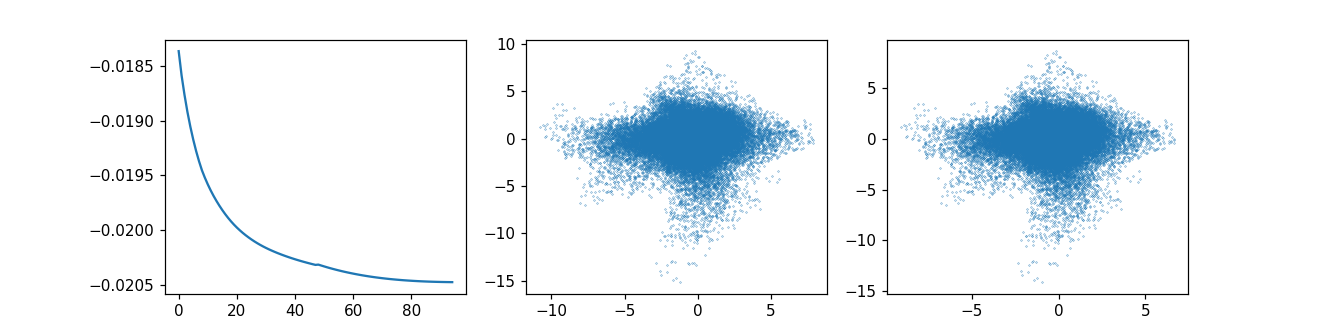

lr changed to: 0.00023005999677179833
1 tensor(90.) -0.018367806617272272 tensor(0.3572, device='cuda:0')
2 tensor(18.6267) -0.018589083841423906 tensor(0.2217, device='cuda:0')
3 tensor(28.1388) -0.018765925075808626 tensor(0.1934, device='cuda:0')
4 tensor(37.0315) -0.01892032896164861 tensor(0.1667, device='cuda:0')
5 tensor(44.9007) -0.01905465073857615 tensor(0.1445, device='cuda:0')
6 tensor(51.5356) -0.01917296110434377 tensor(0.1270, device='cuda:0')
7 tensor(56.9048) -0.01927818477443514 tensor(0.1117, device='cuda:0')
lr changed to: 0.0002070539970946185
8 tensor(61.3374) -0.019371283530288174 tensor(0.0974, device='cuda:0')
9 tensor(8.3174) -0.01945360442836121 tensor(0.0711, device='cuda:0')
10 tensor(15.3144) -0.019520719618145548 tensor(0.0632, device='cuda:0')
11 tensor(21.6560) -0.01958125419809161 tensor(0.0566, device='cuda:0')
12 tensor(27.3939) -0.01963637524216644 tensor(0.0511, device='cuda:0')
13 tensor(32.6501) -0.019686802680335257 tensor(0.0463, device='cuda:0

In [8]:
%matplotlib notebook

k = int(batch_size*0.16)

fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(131)
ax1 = fig.add_subplot(132)
# ax2 = fig.add_subplot(143, projection='3d')
ax3 = fig.add_subplot(133)

# trace = []
change = 100
W_STOP = 1e-6
d_weigths = torch.zeros(dims_remain)
old_d_weights = torch.zeros([1, dims_remain])
torch_pi = torch.acos(torch.zeros(1)).item() * 2 

# for epoch in range(num_epoch):
step0 = 0
angle_delta = 0
while step0 < num_epoch and change > W_STOP:
# for i in range(1000):
    LOSS = 0
    old_weight = torch.clone(model.W1.weight.data)
    for step, ipt in enumerate(loader):
        model.zero_grad()
        ipt = ipt.to(device)
        
        opt = model.forward(ipt)
#------------------------------sphe2cartesin----------------------------------
        
#         opt = torch.atan2(torch.sin(opt), torch.cos(opt))
#         opt = angle2cart(opt)
#         opt = spher2cart
    
#---------------------------------------------------------------
#         loss = entropyLoss(opt.permute(1,0), device=device)
#         loss = entropy(opt, k=k, dis=1)
#         loss = my_loss(opt)
        loss = infonce(opt, ipt)
#         loss = batch_loss(opt)
        loss.backward()
        optimizer.step()
        LOSS+=loss
    d_weigths = model.W1.weight.data - old_weight
    change = norm(d_weigths)**2
    d_weigths = d_weigths.cpu()
    if step > 2:
        angle_delta = torch.arccos(
                    torch.sum(d_weigths * old_d_weights) /
                    (norm(d_weigths) * norm(old_d_weights) + 1e-8)
                ) * 180 / torch_pi
    if angle_delta > 60:
        learning_rate = learning_rate * 0.9
        
        print('lr changed to:', learning_rate)
        
        optimizer.param_groups[0]['lr'] = learning_rate
        old_d_weights = torch.clone(d_weigths)
    elif step == 1:
        old_d_weights = torch.clone(d_weigths)
        
        
        
    LOSS = LOSS.cpu()
    loss_tracker.append(LOSS.detach().numpy()/len(loader.sampler))
    if step0 % 2 == 0:
        
#         index = np.random.randint(0,num_of_img, 2)
        index = [0,1]
        ax.clear()
        ax.plot(loss_tracker[-100:])
        fig.canvas.draw()
    
#         data = model.forward(IPT.T).cpu().detach().numpy()
        data1 = model.forward(mixture.T)
#         data2 = angle2cart(data1).cpu().detach().numpy()
        data1 = data1.cpu().detach().numpy()
        data = (model.W1.weight.data@mixture).cpu().detach().numpy().T
#         data2 = data.cpu().detach().numpy()
        ax1.clear()
        ax1.plot(data[:, index[0]], data[:, index[1]], '.', ms=0.5)
        fig.canvas.draw()
        
#         ax2.clear()
#         ax2.scatter(data2[:,-1], data2[:,-2], data2[:,-3], c = 'r', s=0.1)

# #         ax2.set_xlim3d(-10,10)
# #         ax2.set_ylim3d(-10,10)
# #         ax2.set_zlim3d(-10,10)
        
#         fig.canvas.draw()

        ax3.clear()
        
        ax3.plot(data1[:, index[0]], data1[:, index[1]], '.', ms=0.5)
        fig.canvas.draw()
        

    

    step0 += 1
    print(step0, angle_delta, LOSS.detach().numpy()/len(loader.sampler), change)
    scheduler.step()

In [ ]:



model.cpu()
mixture = mixture.cpu()

data2 = model.W1.weight.data @ mixture

scale = data2.std(axis=1).reshape((-1, 1))
data2 = data2 / scale
a = data2.permute(1, 0)
a = a.reshape(53,63,52,dims_remain)



In [ ]:
# %matplotlib inline
# # plt.plot(data[:,0], data[:,1], '.', ms=0.5)
# # # plt.axis('square')
# plt.figure(figsize=(10,10))
# sub_shape = dims_remain
# for i in range(sub_shape):
#     for j in range(sub_shape):
#         plt.subplot(sub_shape, sub_shape, i*sub_shape+j+1)
#         plt.plot(data2[:, i], data2[:, j], '.', ms=1)
#         plt.axis('square')

In [ ]:
# %matplotlib inline
# plt.plot(data2[2], data2[10],'.')
# plt.axis('square')

In [ ]:
# data_opt = model.forward(mixture.T).cpu().detach().numpy()
# plt.imshow(np.abs(np.corrcoef(data2.T)), cmap='gist_heat')

In [ ]:
# new = np.asanyarray(nib.load('/data/users2/yxiao11/model/ICA/mri_data/icaica1_50.nii').dataobj).reshape(53*63*52, 50).T

In [ ]:
# plt.imshow()

In [ ]:
# %matplotlib inline
# plt.imshow(np.abs(np.corrcoef(new)), cmap='gist_heat')

In [ ]:
data_id = os.listdir('/data/qneuromark/Data/FBIRN/Data_BIDS/Raw_Data/')
path_list = []
for i in data_id:
    nii_path = '/data/qneuromark/Data/FBIRN/Data_BIDS/Raw_Data/' + i + '/ses_01/func/SM.nii'
    path_list.append(nii_path)

In [ ]:
b = nib.load(path_list[2])
nifiti = np.array(a)
new_image = nib.Nifti1Image(nifiti, affine=b.affine, header=b.header)
# nib.save(new_image, 'mri_data/adam_meanNN_' + str(dims_remain) +'_' + str(batch_size) + 'batch')
nib.save(new_image, './mri_data/knn.nii')

In [ ]:
# data_id = os.listdir('/data/qneuromark/Data/FBIRN/Data_BIDS/Raw_Data/')
# path_list = []
# for i in data_id:
#     nii_path = '/data/qneuromark/Data/FBIRN/Data_BIDS/Raw_Data/' + i + '/ses_01/func/SM.nii'
#     path_list.append(nii_path)

# def norm(x):
#     """Computes the norm of a vector or the Frobenius norm of a
#     matrix_rank
#     """
#     return torch.norm(torch.flatten(x))

# def get_mixture(path_list, dims_remain):
#     print('getting file:', 0)
#     mri = nib.load(path_list[0])
#     data = np.asanyarray(mri.dataobj)
#     list_x = []
#     for j in range(int(data.shape[-1])):
#         list_x.append(np.expand_dims(data[:,:,:,j].flatten(),1))
#     mixture = np.concatenate(list_x,axis=1).T
    
#     for i in range(50):
#         print('getting file:', i)
#         mri = nib.load(path_list[i])
#         data = np.asanyarray(mri.dataobj)
#         list_x = []
#         for j in range(int(data.shape[-1])):
#             list_x.append(np.expand_dims(data[:,:,:,j].flatten(),1))

#         conc_x = np.concatenate(list_x,axis=1)
#         mixture = np.concatenate((mixture, conc_x.T), axis=0)
        
# #     del mri, data, list_x, conc_x
# #     mixture = np.float64(mixture.T)
#     print('the shape of mixture is:', mixture.shape)
#     print('whitening')
#     mixture, white, dewhite = ica.pca_whiten(mixture, dims_remain)
#     mixture = torch.from_numpy(mixture).type(torch.float32)
#     print('done')
#     return mixture, white, dewhite

In [ ]:
# mixture, white, dewhite = get_mixture(path_list, 50)

In [ ]:
# np.save('mixture.npy', mixture)